Required Libraries

In [ ]:
!pip install pandas numpy scikit-learn sentence-transformers seaborn matplotlib streamlit altair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00


Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt

Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading the Dataset and Spliting by user type

In [ ]:
# Load the Dataset
df = pd.read_csv('/content/drive/MyDrive/Task3_Binumol_George/Cleaned_User_Matching_Dataset.csv')

# Split by user type
founders = df[df['user_id'].str.startswith('F')].reset_index(drop=True)
providers = df[df['user_id'].str.startswith('S')].reset_index(drop=True)

Initializing SentenceTransformer and Defining Matching score logic

In [ ]:
# Initialize SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')  # Small and fast for embeddings

# Define Matching Score Logic
def compute_match_score(founder, provider):
    score = 0
    weights = {
        "industry": 20,
        "skill": 30,
        "project_type": 25,
        "timeline": 15,
        "stage": 10
    }

    # 1. Industry Relevance
    if founder['startup_industry'].strip().lower() == provider['industry_preference'].strip().lower():
        score += weights["industry"]

    # 2. Skill Match (using semantic similarity)
    skill_sim = util.cos_sim(
        model.encode(founder['tech_requirement'], convert_to_tensor=True),
        model.encode(provider['core_skill'], convert_to_tensor=True)
    ).item()
    score += weights["skill"] * skill_sim

    # 3. Project Type Compatibility (fuzzy match using embeddings)
    proj_type_sim = util.cos_sim(
        model.encode(founder['project_need'], convert_to_tensor=True),
        model.encode(provider['preferred_project_type'], convert_to_tensor=True)
    ).item()
    score += weights["project_type"] * proj_type_sim

    # 4. Timeline Fit (exact match)
    if founder['project_deadline'].strip().lower() == provider['availability'].strip().lower():
        score += weights["timeline"]

    # 5. Stage vs Expertise (bonus)
    if founder['startup_stage'].strip().lower() in provider['expertise_area'].strip().lower():
        score += weights["stage"]

    return round(score, 2)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating Match Matrix (Founders → Providers)

In [ ]:
match_matrix = pd.DataFrame(index=founders['user_id'], columns=providers['user_id'])

for i, f_row in founders.iterrows():
    for j, p_row in providers.iterrows():
        match_score = compute_match_score(f_row, p_row)
        match_matrix.loc[f_row['user_id'], p_row['user_id']] = match_score

Top 3 Recommendations per Founder without Key Reasons

In [ ]:
top_founder_matches = {}

for founder_id in match_matrix.index:
    sorted_providers = match_matrix.loc[founder_id].sort_values(ascending=False).head(3)
    top_founder_matches[founder_id] = [(pid, match_matrix.loc[founder_id, pid]) for pid in sorted_providers.index]

Top 3 Recommendations per Provider without Key Reasons

In [ ]:
top_provider_matches = {}

for provider_id in match_matrix.columns:
    sorted_founders = match_matrix[provider_id].sort_values(ascending=False).head(3)
    top_provider_matches[provider_id] = [(fid, match_matrix.loc[fid, provider_id]) for fid in sorted_founders.index]

Summary Tables

In [ ]:
def summarize_matches(match_dict, reverse=False):
    summary_rows = []
    for user_id, matches in match_dict.items():
        for match_id, score in matches:
            row = {
                'User ID': user_id,
                'Matched With': match_id,
                'Score': score
            }
            summary_rows.append(row)
    return pd.DataFrame(summary_rows)

founder_summary = summarize_matches(top_founder_matches)
provider_summary = summarize_matches(top_provider_matches)

Outputs:

In [ ]:
founder_summary.to_csv("/content/drive/MyDrive/Task3_Binumol_George/Top3_Founder_Matches.csv", index=False)
provider_summary.to_csv("/content/drive/MyDrive/Task3_Binumol_George/Top3_Provider_Matches.csv", index=False)
match_matrix.to_csv("/content/drive/MyDrive/Task3_Binumol_George/Full_Match_Matrix.csv")

Visualization - Heatmap

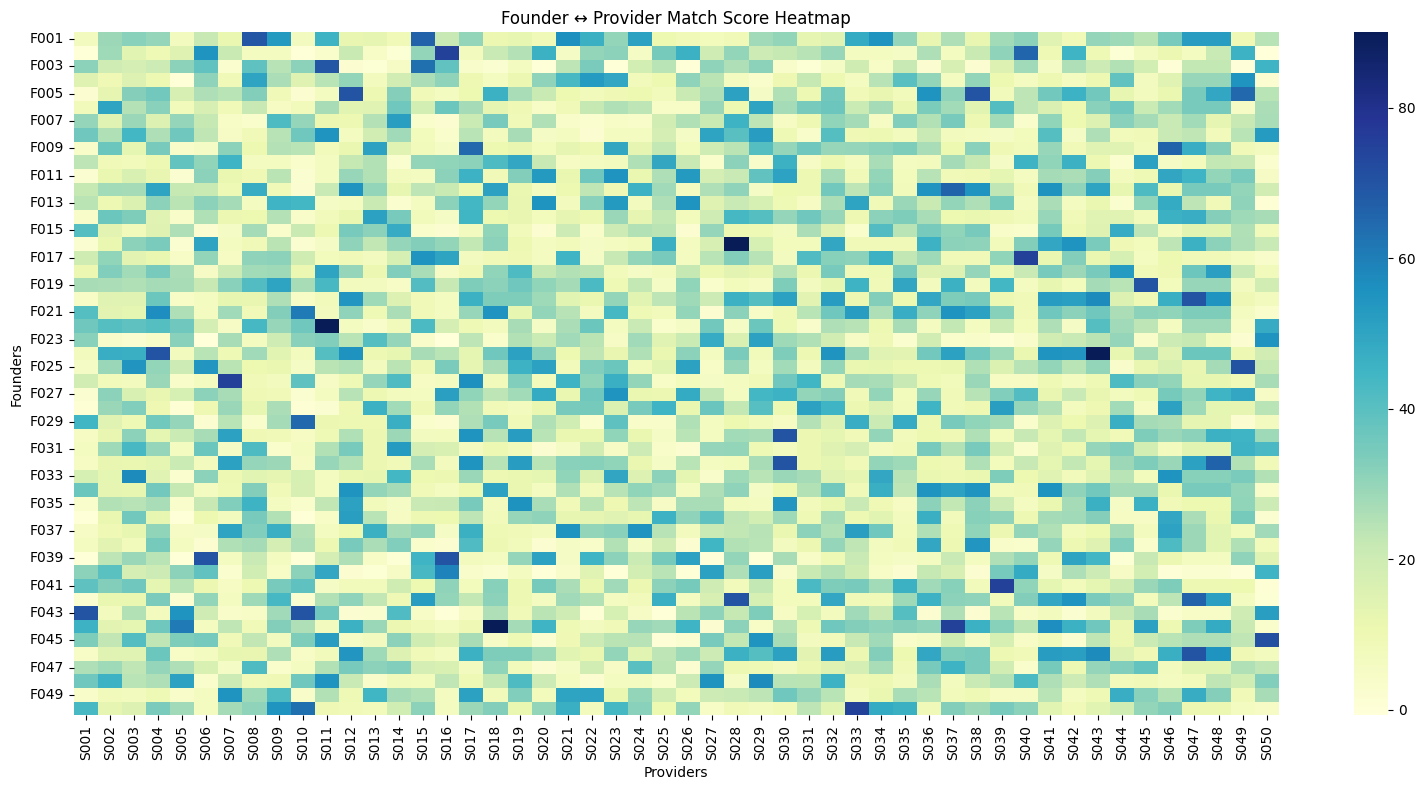

In [ ]:
plt.figure(figsize=(16, 8))
sns.heatmap(match_matrix.astype(float), cmap='YlGnBu')
plt.title("Founder ↔ Provider Match Score Heatmap")
plt.xlabel("Providers")
plt.ylabel("Founders")
plt.tight_layout()
plt.show()

Updated matching function to also return key reasons

In [ ]:
# Updated matching function that also returns key reasons
def compute_match_score_with_reasons(founder, provider):
    score = 0
    reasons = []
    weights = {
        "industry": 20,
        "skill": 30,
        "project_type": 25,
        "timeline": 15,
        "stage": 10
    }

    # 1. Industry Relevance
    if founder['startup_industry'].strip().lower() == provider['industry_preference'].strip().lower():
        score += weights["industry"]
        reasons.append("Industry Match")

    # 2. Skill Match (Semantic similarity)
    skill_sim = util.cos_sim(
        model.encode(founder['tech_requirement'], convert_to_tensor=True),
        model.encode(provider['core_skill'], convert_to_tensor=True)
    ).item()
    skill_score = weights["skill"] * skill_sim
    score += skill_score
    if skill_sim > 0.6:
        reasons.append("Skill Match")

    # 3. Project Type Compatibility
    proj_sim = util.cos_sim(
        model.encode(founder['project_need'], convert_to_tensor=True),
        model.encode(provider['preferred_project_type'], convert_to_tensor=True)
    ).item()
    proj_score = weights["project_type"] * proj_sim
    score += proj_score
    if proj_sim > 0.6:
        reasons.append("Project Type Match")

    # 4. Timeline Fit
    if founder['project_deadline'].strip().lower() == provider['availability'].strip().lower():
        score += weights["timeline"]
        reasons.append("Timeline Fit")

    # 5. Bonus: Stage Match
    if founder['startup_stage'].strip().lower() in provider['expertise_area'].strip().lower():
        score += weights["stage"]
        reasons.append("Stage Alignment")

    return round(score, 2), ", ".join(reasons)


Top 3 Recommendations per Founder with Key Reasons

In [ ]:
top_matches_with_reasons = []

for i, f_row in founders.iterrows():
    founder_id = f_row['user_id']
    scores = []

    for j, p_row in providers.iterrows():
        provider_id = p_row['user_id']
        match_score, reason = compute_match_score_with_reasons(f_row, p_row)
        scores.append({
            'Founder ID': founder_id,
            'Matched Provider ID': provider_id,
            'Match Score': match_score,
            'Key Matching Reasons': reason
        })

    # Sort and take Top 3
    top3 = sorted(scores, key=lambda x: x['Match Score'], reverse=True)[:3]
    top_matches_with_reasons.extend(top3)


In [ ]:
top3_summary_df = pd.DataFrame(top_matches_with_reasons)
top3_summary_df = top3_summary_df.sort_values(by=['Founder ID', 'Match Score'], ascending=[True, False])

# Save or display
top3_summary_df.to_csv("/content/drive/MyDrive/Task3_Binumol_George/Top3_Founder_Matches_With_Reasons.csv", index=False)
top3_summary_df.head(10)


,Founder ID,Matched Provider ID,Match Score,Key Matching Reasons
0,F001,S008,69.43,"Industry Match, Skill Match, Timeline Fit"
1,F001,S015,66.38,"Industry Match, Skill Match, Timeline Fit"
2,F001,S021,56.28,"Industry Match, Skill Match"
3,F002,S016,75.00,"Industry Match, Skill Match, Project Type Match"
4,F002,S040,65.31,"Industry Match, Project Type Match, Timeline Fit"
5,F002,S006,55.00,"Skill Match, Project Type Match"
6,F003,S011,69.28,"Industry Match, Skill Match, Timeline Fit"
7,F003,S015,63.28,"Industry Match, Project Type Match, Timeline Fit"
8,F003,S050,45.33,"Skill Match, Timeline Fit"
9,F004,S049,55.00,"Skill Match, Project Type Match"


Top 3 Recommendations per Providers with Key Reasons

In [ ]:
top_provider_matches_with_reasons = []

for j, p_row in providers.iterrows():
    provider_id = p_row['user_id']
    scores = []

    for i, f_row in founders.iterrows():
        founder_id = f_row['user_id']
        match_score, reason = compute_match_score_with_reasons(f_row, p_row)
        scores.append({
            'Provider ID': provider_id,
            'Matched Founder ID': founder_id,
            'Match Score': match_score,
            'Key Matching Reasons': reason
        })

    # Sort and take Top 3
    top3 = sorted(scores, key=lambda x: x['Match Score'], reverse=True)[:3]
    top_provider_matches_with_reasons.extend(top3)


In [ ]:
top3_provider_df = pd.DataFrame(top_provider_matches_with_reasons)
top3_provider_df = top3_provider_df.sort_values(by=['Provider ID', 'Match Score'], ascending=[True, False])

# Save or preview
top3_provider_df.to_csv("/content/drive/MyDrive/Task3_Binumol_George/Top3_Provider_Matches_With_Reasons.csv", index=False)
top3_provider_df.head(10)

,Provider ID,Matched Founder ID,Match Score,Key Matching Reasons
0,S001,F043,70.00,"Skill Match, Project Type Match, Timeline Fit"
1,S001,F044,46.02,"Industry Match, Project Type Match"
2,S001,F029,44.96,"Project Type Match, Timeline Fit"
3,S002,F006,50.32,"Industry Match, Timeline Fit"
4,S002,F024,47.36,"Project Type Match, Timeline Fit"
5,S002,F048,45.74,"Industry Match, Project Type Match"
6,S003,F033,57.19,"Industry Match, Skill Match"
7,S003,F025,54.80,"Industry Match, Project Type Match"
8,S003,F024,47.06,"Project Type Match, Timeline Fit"
9,S004,F024,70.00,"Skill Match, Project Type Match, Timeline Fit"
